<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/modeling_and_prediction_Quantile_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM BASELINE MODEL

In diesem Skript wird ein erstes Modell erzeugt, um aus den gemssenen Globalstrahlungsdaten den UVI zu berechen.

In [1]:
# Verbinden mit der Google-Drive
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install keras

In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Funktionen:

In [4]:
# sMAPE Funktion zum brechnen des symmetric mean absolute percentage error
def smape(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    denom = K.abs(y_true) + K.abs(y_pred)
    return 200.0 * K.mean(diff / (denom + K.epsilon()))

## Import

In [5]:
# Pfad zur CSV-Datei auf Google-Drive
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

In [6]:
# Pfad zum Abspeichern des trainierten Modells in Google-Drive

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'

# Pfad für den Testdatensatz

testdata_path_X = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_X.csv'
testdata_path_Y = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_Y.csv'

# Pfad für die Logdatei

text_file_path = "/content/drive/MyDrive/Colab_Notebooks/LSTM_Model/model_results.txt"

In [7]:
# Import der Messdaten
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)

In [8]:
# Import der Vorhersagedaten
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

In [9]:
# Konvertiere die Zeitspalten in ein gemeinsames Format und führe einen Merge der Datensätze durch
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

In [10]:
# Spalten in den Messdaten
df_Messdaten.columns

Index(['Datetime', 'Observation_period', 'Clear_sky_GHI', 'Clear_sky_BHI',
       'GHI', 'BHI', 'UVI', 'UVA', 'UVB', 'erythem', 'Datum', 'Uhrzeit',
       'Messzeitpunkt', 'ghi', 'Dif', 'Glo_SPLite', 'Dir', 'Temp',
       'DiffGreater2', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos',
       'Date', 'Hour'],
      dtype='object')

## Funktionsdefinition:

In [11]:
def quantile_loss(q, y_true, y_pred):
    """Berechnet den Pinball Loss für mehrere Quantile."""
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)  # Reduziere entlang der letzten Achse

In [12]:
def multi_quantile_loss(y_true, y_pred):
    """Berechnet den Gesamt-Quantile-Loss für alle Quantile."""
    losses = [quantile_loss(q, y_true[:, i], y_pred[:, i]) for i, q in enumerate(quantiles)]
    return tf.reduce_mean(losses)  # Mittelwert über alle Quantile

## Config

In [13]:
model_name = "LSTM_mit_Vorhersagewerten_1Step"

In [14]:
# Beispiel: Nur 'SZA' als Feature und 'UVI' als Label
columns_X = ['Clear_sky_GHI', 'Clear_sky_BHI', 'GHI', 'BHI', 'Temp', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']
columns_y = ['UVI']

In [15]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [16]:
model_config = {
    "units_1": 64,
    "units_2": 32,
    "dropout_rate": 0.1,
    "final_activation": "linear"
}

In [17]:
training_config = {
    "loss": multi_quantile_loss,
    "optimizer": "adam",
    "metrics": [
        "mse",
        "mae",
        "mape",
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
}

In [18]:
fit_config = {
    "epochs": 10,
    "batch_size": 32,
    "sequence_length": 16
}

## Setup

In [19]:
df = df_Messdaten.copy()  # deine Messdaten

total_length = len(df)
train_size   = round(total_length * 0.80)
val_size     = round(total_length * 0.10)
test_size    = total_length - train_size - val_size  # restliche 10%

# Skaliere X und Y separat (immer zuerst nur auf dem Trainingsbereich fitten!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 1) Nur Trainingsdatensatz extrahieren
train_df = df.iloc[:train_size]
# Fit des Scalers NUR auf Trainingsdaten
train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])

# 2) Für Validation
val_df = df.iloc[train_size : train_size + val_size].copy()
val_df[columns_X] = scaler_X.transform(val_df[columns_X])
val_df[columns_y] = scaler_y.transform(val_df[columns_y])

# 3) Für Test
test_df = df.iloc[train_size + val_size :].copy()
test_df[columns_X] = scaler_X.transform(test_df[columns_X])
test_df[columns_y] = scaler_y.transform(test_df[columns_y])

# Kontrolle
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (77386, 26)
Val: (9673, 26)
Test: (9673, 26)


<ipython-input-19-76f70d0c4b52>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
<ipython-input-19-76f70d0c4b52>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])


In [20]:
def create_sequence(X, y, seq_length):
    sequences = []
    labels = []
    for stop_idx in range(seq_length, len(X)):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values  # (seq_length, num_features)
        y_label = y.iloc[stop_idx]                           # Wert am Zeitpunkt 'stop_idx'
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [21]:
def create_sequence_OneStepAhead(X, y, seq_length):
    sequences = []
    labels = []
    # bis len(X)-1, damit "stop_idx + 1" nicht out-of-range ist
    for stop_idx in range(seq_length, len(X)-1):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values
        y_label = y.iloc[stop_idx + 1]  # => label ist der nächste Zeitschritt
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [22]:
sequence_len = fit_config["sequence_length"]

X_train_seq, y_train_seq = create_sequence_OneStepAhead(train_df[columns_X], train_df[columns_y], sequence_len)
X_val_seq,   y_val_seq   = create_sequence_OneStepAhead(val_df[columns_X],   val_df[columns_y],   sequence_len)
X_test_seq,  y_test_seq  = create_sequence_OneStepAhead(test_df[columns_X],  test_df[columns_y],  sequence_len)

y_train_seq = np.tile(y_train_seq, (1, len(quantiles)))  # (77369, 5)
y_val_seq   = np.tile(y_val_seq, (1, len(quantiles)))
y_test_seq  = np.tile(y_test_seq, (1, len(quantiles)))

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq:", X_val_seq.shape,"y_val_seq:", y_val_seq.shape)
print("X_test_seq:", X_test_seq.shape,"y_test_seq:",  y_test_seq.shape)

X_train_seq: (77369, 16, 10) y_train_seq: (77369, 5)
X_val_seq: (9656, 16, 10) y_val_seq: (9656, 5)
X_test_seq: (9656, 16, 10) y_test_seq: (9656, 5)


In [23]:
X_test_2D = pd.DataFrame(X_test_seq.reshape(9656, -1))
y_test_2D = pd.DataFrame(y_test_seq.reshape(9656, -1))

In [24]:
# abspeichern der Testdaten in der Google-Drive
X_test_2D.to_csv(testdata_path_X, index = False)
y_test_2D.to_csv(testdata_path_Y, index = False)

In [25]:
input_shape = (16, 1)

In [26]:
def build_and_compile_model(model_config, training_config, input_shape):

    model = Sequential()

    # Erste LSTM-Schicht
    model.add(
        LSTM(
            units=model_config["units_1"],
            return_sequences=True,
            input_shape=input_shape
        )
    )
    model.add(Dropout(model_config["dropout_rate"]))

    # Zweite LSTM-Schicht
    model.add(LSTM(units=model_config["units_2"]))

    # Dense-Ausgangsschicht mit 3 Outputs (für 10%, 50%, 90% Quantil)
    model.add(Dense(len(quantiles), activation=model_config["final_activation"]))

    # Kompilieren mit custom loss
    model.compile(**training_config)

    return model

In [27]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # z.B. (16, 1)

model = build_and_compile_model(
    model_config=model_config,
    training_config=training_config,
    input_shape=input_shape
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,781 (124.14 KB)

 Trainable params: 31,781 (124.14 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=fit_config["epochs"],
    batch_size=fit_config["batch_size"]
)

Epoch 1/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 63s 24ms/step - loss: 0.0112 - mae: 0.0446 - mape: 4228.6445 - mse: 0.0068 - rmse: 0.0791 - val_loss: 0.0149 - val_mae: 0.0571 - val_mape: 50.7916 - val_mse: 0.0091 - val_rmse: 0.0955
Epoch 2/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0078 - mae: 0.0303 - mape: 2316.8013 - mse: 0.0034 - rmse: 0.0579 - val_loss: 0.0140 - val_mae: 0.0526 - val_mape: 48.4118 - val_mse: 0.0074 - val_rmse: 0.0861
Epoch 3/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 0.0075 - mae: 0.0289 - mape: 1738.7629 - mse: 0.0031 - rmse: 0.0559 - val_loss: 0.0138 - val_mae: 0.0509 - val_mape: 47.3058 - val_mse: 0.0070 - val_rmse: 0.0835
Epoch 4/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 47s 20ms/step - loss: 0.0073 - mae: 0.0285 - mape: 1559.5306 - mse: 0.0031 - rmse: 0.0555 - val_loss: 0.0133 - val_mae: 0.0496 - val_mape: 41.8603 - val_mse: 0.0067 - val_rmse: 0.0817
Epoch 5/10
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - loss: 0.0072 - mae: 0.0278 - mape: 121

In [30]:
# Berechnen des vorhergesagten UVI
y_pred = model.predict(X_test_seq)

302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [31]:
print(y_train_seq.shape, y_pred.shape)

(77369, 5) (9656, 5)


In [32]:
# 2) Evaluieren (Keras-integrierte Metriken)
val_results = model.evaluate(X_val_seq, y_val_seq, verbose=0)
test_results = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print("Model metrics names:", model.metrics_names)

y_val_pred = model.predict(X_val_seq)  # Shape: (9656, 5)
y_test_pred = model.predict(X_test_seq)

# 50%-Quantil aus den Vorhersagen extrahieren
y_val_pred_median = y_val_pred[:, 2]  # Index 2 = 50%-Quantil
y_test_pred_median = y_test_pred[:, 2]

if y_val_seq.shape[1] == 5:
    y_val_seq = y_val_seq[:, 0]  # Verwende nur die echte UV-Strahlung
    y_test_seq = y_test_seq[:, 0]

# R²-Score berechnen
val_r2  = r2_score(y_val_seq, y_val_pred_median)
test_r2 = r2_score(y_test_seq, y_test_pred_median)

# 4) Dictionary bauen
metrics = {
    "val_loss": val_results[0],
    "val_mse":  val_results[1],
    "val_mae":  val_results[2],
    "val_rmse": val_results[3],
    "test_loss": test_results[0],
    "test_mse":  test_results[1],
    "test_mae":  test_results[2],
    "test_rmse": test_results[3],
    "val_r2": val_r2,
    "test_r2": test_r2
}

Model metrics names: ['loss', 'compile_metrics']
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [33]:
print("y_val_seq shape:", y_val_seq.shape)  # Erwartet: (9656, 1) oder (9656,)
print("y_val_pred_median shape:", y_val_pred_median.shape)  # Erwartet: (9656,)

y_val_seq shape: (9656,)
y_val_pred_median shape: (9656,)


In [34]:
y_pred = y_pred.flatten()
y_test_seq = y_test_seq.flatten()

In [35]:
type(y_pred)

numpy.ndarray

In [36]:
# Püfen, ob die Vorhersage den selben Shape hat wie
print(y_pred.shape, y_test_seq.shape)

(48280,) (9656,)


In [37]:
# Abspeichern des trainierten Modells und der Gewichte

model.save(model_path)
model.save_weights(weights_path)

# Abspeichern des Testdatensatzes für eine spätere Auswertung

## Berechnung der Qualitätsparameter:

In [44]:
def compare_model_output(model, X_test, y_test, output_indices=None, plot_indices=None):
    """
    Vergleicht die tatsächlichen Werte mit den vorhergesagten Werten für beliebige Output-Features.
    Plottet die Werte und berechnet Metriken.

    Parameter:
    - model: Trainiertes Keras-Modell
    - X_test: Test-Daten für Eingabe (Shape: (Anzahl, Timesteps, Features))
    - y_test: Tatsächliche Werte (Shape: (Anzahl, Output_Features) oder (Anzahl,))
    - output_indices: Liste der Output-Indizes, die ausgewertet werden sollen (z.B. [2] für das 50%-Quantil)
                      Falls None, werden alle Outputs verwendet.
    - plot_indices: Optionaler Tupel (start, end), um Detailplots für einen bestimmten Bereich zu zeigen.
    """

    # Vorhersage berechnen (Shape: (Anzahl, Output_Features))
    y_pred = model.predict(X_test)

    # Falls keine spezifischen Output-Indices angegeben sind, alle nehmen
    if output_indices is None:
        output_indices = list(range(y_pred.shape[1]))  # Alle Spalten

    # Falls y_test mehrdimensional ist, nur die relevanten Spalten auswählen
    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_test = y_test[:, 0]  # Nur die echte Zielvariable verwenden

    # Metriken für jeden gewählten Output berechnen
    mse_values = []
    mae_values = []
    for idx in output_indices:
        mse = mean_squared_error(y_test, y_pred[:, idx])
        mae = mean_absolute_error(y_test, y_pred[:, idx])
        mse_values.append(mse)
        mae_values.append(mae)
        print(f"Feature {idx}: MSE = {mse:.4f}, MAE = {mae:.4f}")

    # Gesamten Vergleich plotten
    plt.figure(figsize=(12, 4))
    for idx in output_indices:
        plt.plot(y_pred[:, idx], label=f'Vorhersage (Feature {idx})', alpha=0.7)
    plt.plot(y_test, label='Tatsächlicher Wert', alpha=0.7, linestyle='dashed', color='black')
    plt.title('Vergleich Vorhersage vs. Tatsächlicher Wert')
    plt.legend()
    plt.show()

    # Optionaler Detailplot für einen bestimmten Indexbereich
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 4))
        for idx in output_indices:
            plt.plot(np.arange(start, end), y_pred[start:end, idx], label=f'Vorhersage (Feature {idx})', alpha=0.7)
        plt.plot(np.arange(start, end), y_test[start:end], label='Tatsächlicher Wert', alpha=0.7, linestyle='dashed', color='black')
        plt.title(f'Detailplot (Index {start} - {end})')
        plt.legend()
        plt.show()

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Feature 0: MSE = 0.0111, MAE = 0.0700
Feature 1: MSE = 0.0070, MAE = 0.0536
Feature 2: MSE = 0.0053, MAE = 0.0450
Feature 3: MSE = 0.0060, MAE = 0.0475
Feature 4: MSE = 0.0095, MAE = 0.0600


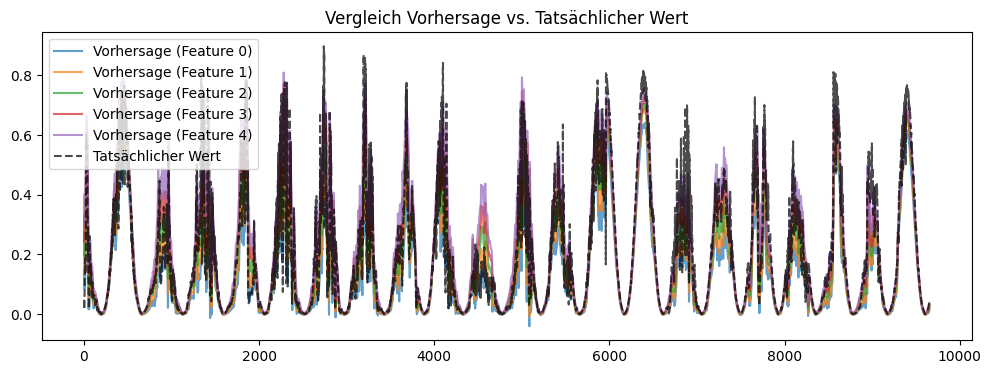

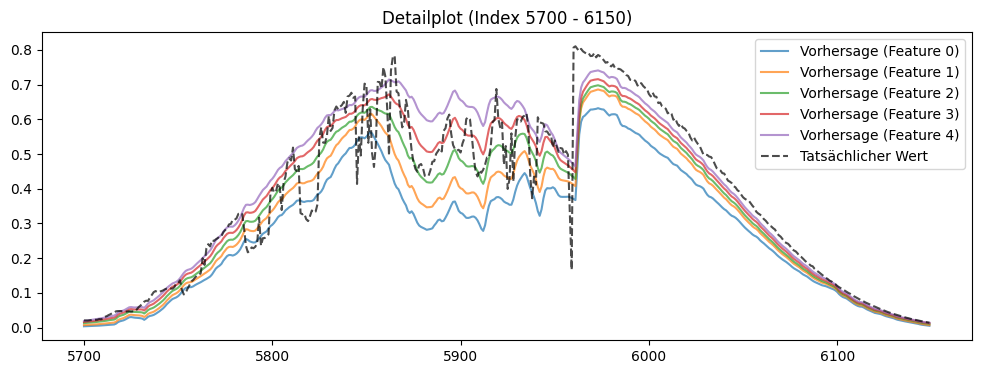

In [53]:
# Funktion aufrufen
compare_model_output(model, X_test_seq, y_test_seq, output_indices=[0, 1, 2, 3, 4], plot_indices=(5700, 6150))  # Mehrere Quantile vergleichen

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Feature 0: MSE = 0.0060, MAE = 0.0497
Feature 1: MSE = 0.0026, MAE = 0.0306
Feature 2: MSE = 0.0025, MAE = 0.0258
Feature 3: MSE = 0.0051, MAE = 0.0401
Feature 4: MSE = 0.0097, MAE = 0.0613


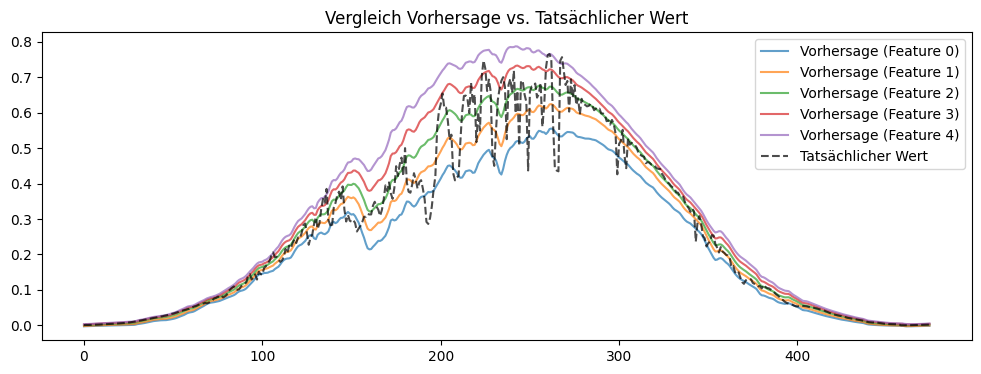

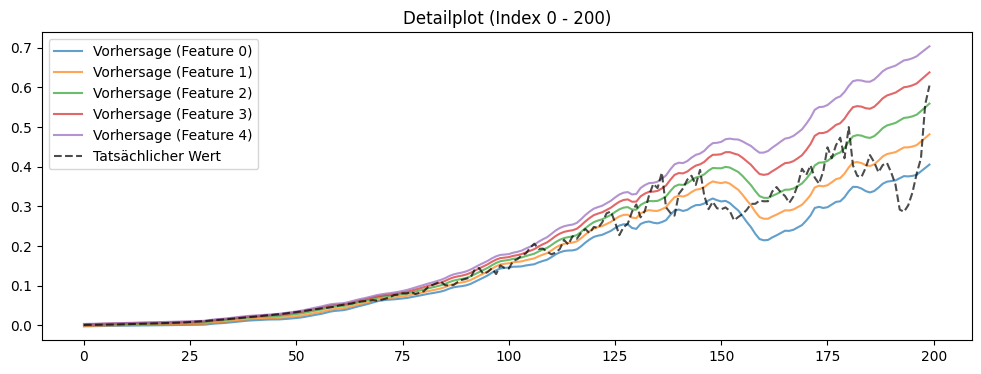

In [51]:
compare_model_output(model, X_test_seq[200:675], y_test_seq[200:675], output_indices=[0, 1, 2, 3, 4], plot_indices=(0, 200))  # Mehrere Quantile vergleichen

In [73]:
def check_quantile_violations(y_true, y_pred):
    """
    Berechnet, wie oft die gemessenen Werte (y_true)
    das 10%- und 25%-Quantil unterschreiten sowie
    das 75%- und 90%-Quantil überschreiten. Zusätzlich
    wird der prozentuale Anteil dieser Verletzungen
    (bezogen auf alle Datenpunkte) ausgegeben.

    Parameter:
    ----------
    y_true : numpy.ndarray
        1D-Array mit den tatsächlichen Messwerten (Form: (N,))
    y_pred : numpy.ndarray
        2D-Array der vorhergesagten Quantile (Form: (N, 5)).
        Spalten: [10%-Quantil, 25%-Quantil, 50%-Quantil, 75%-Quantil, 90%-Quantil]

    Rückgabe:
    ----------
    dict
        Dictionary mit absoluten Anzahlen und prozentualen Anteilen.
    """

    n = len(y_true)  # Gesamtzahl der Datenpunkte

    # Absolutzahlen für Verletzungen berechnen
    below_10p = np.sum(y_true < y_pred[:, 0])
    below_25p = np.sum(y_true < y_pred[:, 1])
    above_75p = np.sum(y_true > y_pred[:, 3])
    above_90p = np.sum(y_true > y_pred[:, 4])

    # Prozentsätze berechnen
    below_10p_pct = (below_10p / n) * 100
    below_25p_pct = (below_25p / n) * 100
    above_75p_pct = (above_75p / n) * 100
    above_90p_pct = (above_90p / n) * 100

    return {
        'below_10_percentile': {
            'count': below_10p,
            'percentage': below_10p_pct
        },
        'below_25_percentile': {
            'count': below_25p,
            'percentage': below_25p_pct
        },
        'above_75_percentile': {
            'count': above_75p,
            'percentage': above_75p_pct
        },
        'above_90_percentile': {
            'count': above_90p,
            'percentage': above_90p_pct
        }
    }

In [74]:
results = check_quantile_violations(y_test_seq, model.predict(X_test_seq))

302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [75]:
print(results)

{'below_10_percentile': {'count': 700, 'percentage': 7.249378624689312}, 'below_25_percentile': {'count': 1655, 'percentage': 17.13960231980116}, 'above_75_percentile': {'count': 4055, 'percentage': 41.994614747307374}, 'above_90_percentile': {'count': 2633, 'percentage': 27.26801988400994}}


In [41]:
def log_model_results_to_csv(
    model_name,
    model_config,        # Dictionary mit Modell-Hyperparametern
    training_config,     # Dictionary mit Compile-Einstellungen (model.compile)
    fit_config,          # <--- NEU: Dictionary mit fit-Parametern (epochs, batch_size, sequence_length)
    metrics,             # Dictionary mit erzielten Metriken
    csv_path="model_results.csv"
):

    # 1) Zusammenführen aller Informationen in ein Dictionary
    results_dict = {
        "model_name": model_name
    }

    # Modell-Konfigurationswerte hinzufügen
    for k, v in model_config.items():
        results_dict[f"model_config.{k}"] = v

    # Trainings-Konfigurationswerte (compile) hinzufügen
    for k, v in training_config.items():
        results_dict[f"training_config.{k}"] = str(v)

    # Fit-Konfigurationswerte (fit) hinzufügen
    for k, v in fit_config.items():
        results_dict[f"fit_config.{k}"] = v

    # Metrics hinzufügen
    results_dict.update(metrics)

    # 2) Anzeige in der Konsole
    print("=== Model Results ===")
    for key, value in results_dict.items():
        print(f"{key}: {value}")
    print("======================\n")

    # 3) In einen DataFrame umwandeln (eine Zeile pro Modell)
    df_results = pd.DataFrame([results_dict])

    # 4) Schreiben oder Anhängen in die CSV
    if not os.path.exists(csv_path):
        df_results.to_csv(csv_path, index=False)
    else:
        df_results.to_csv(csv_path, mode='a', index=False, header=False)

In [42]:
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

In [43]:
log_model_results_to_csv(
    model_name=model_name,
    model_config=model_config,
    training_config=training_config,
    fit_config=fit_config,        # <--- Neues Argument
    metrics=metrics,
    csv_path="model_results.csv"
)

=== Model Results ===
model_name: LSTM_mit_Vorhersagewerten_1Step
model_config.units_1: 64
model_config.units_2: 32
model_config.dropout_rate: 0.1
model_config.final_activation: linear
training_config.loss: <function multi_quantile_loss at 0x7cb211bce200>
training_config.optimizer: adam
training_config.metrics: ['mse', 'mae', 'mape', <RootMeanSquaredError name=rmse>]
fit_config.epochs: 10
fit_config.batch_size: 32
fit_config.sequence_length: 16
val_loss: 0.013558171689510345
val_mse: 0.006060111802071333
val_mae: 0.04676641896367073
val_rmse: 39.83203887939453
test_loss: 0.016208425164222717
test_mse: 0.007769703399389982
test_mae: 0.05522530525922775
test_rmse: 63.66067123413086
val_r2: 0.8856159539799877
test_r2: 0.8726207445596357

